In [436]:
%load_ext autoreload
%autoreload 1
import scipy.io as sio
import glob
import numpy as np
from src.data.phantom.materials import load_alma,Material, load_firenze
from src.models.ig_cnn import wavelength2rgb
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [437]:
alma = load_alma()


In [438]:
vis = glob.glob('../data/raw/phantoms/TIF.8bit_norm.255/Ch*_VIS_*.tif')
nir = glob.glob('../data/raw/phantoms/TIF.8bit_norm.255/Ch*_NIR_*.tif')
mask = sio.loadmat('../data/raw/phantoms/bianco_mask.mat')['res_2d']
max_value = 255.0

layers = [*vis, *nir]
x,y = plt.imread(layers[0]).shape
z = len(layers)

raw_img = np.zeros((x,y,z))
for i, l in enumerate(layers):
    raw_img[:,:,i] = plt.imread(l)

raw_img /= max_value

In [347]:
z_size = raw_img.shape[-1]
pigments = []
padding = 4
for mask_id in range(1, np.max(mask)+1):
    mask_multid = np.repeat(
        np.expand_dims(
           (mask == mask_id),
            axis=-1),
        repeats=z_size,
        axis=-1
        )

    x_size = np.max(np.sum(mask_multid[:,:,1], axis=0))
    y_size = np.max(np.sum(mask_multid[:,:,1], axis=1))
    square = np.reshape(raw_img[mask_multid], (x_size, y_size, z_size))

    no_draw = square[:, :int(square.shape[1]/2)-padding,:]
    draw = square[:, int(square.shape[1]/2)+padding:,:]

    pigments.append((no_draw, draw))

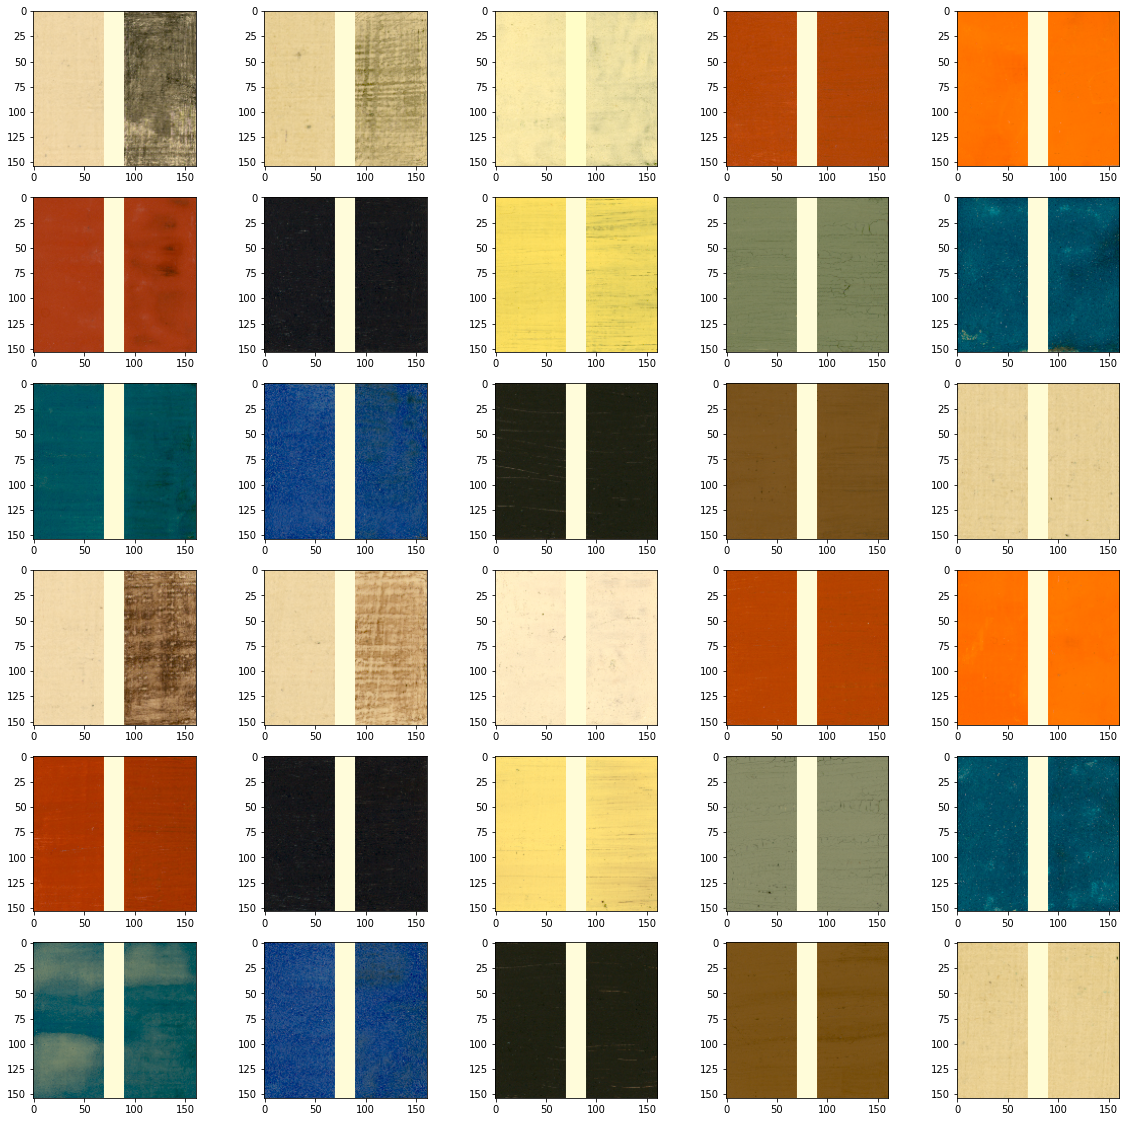

In [349]:
fig, axs = plt.subplots(6,int(len(pigments)/6),figsize=(20,20))
for i, pigment in enumerate(pigments):
    no_draw, draw = pigment
    merged_pigment = np.concatenate((no_draw,
                        np.ones((draw.shape[0], 20, draw.shape[-1])),
                        draw),
                       axis=1)
    axs[i % axs.shape[0], i // axs.shape[0]].imshow(
       wavelength2rgb(
       merged_pigment[:,:,:16]
           )
    )

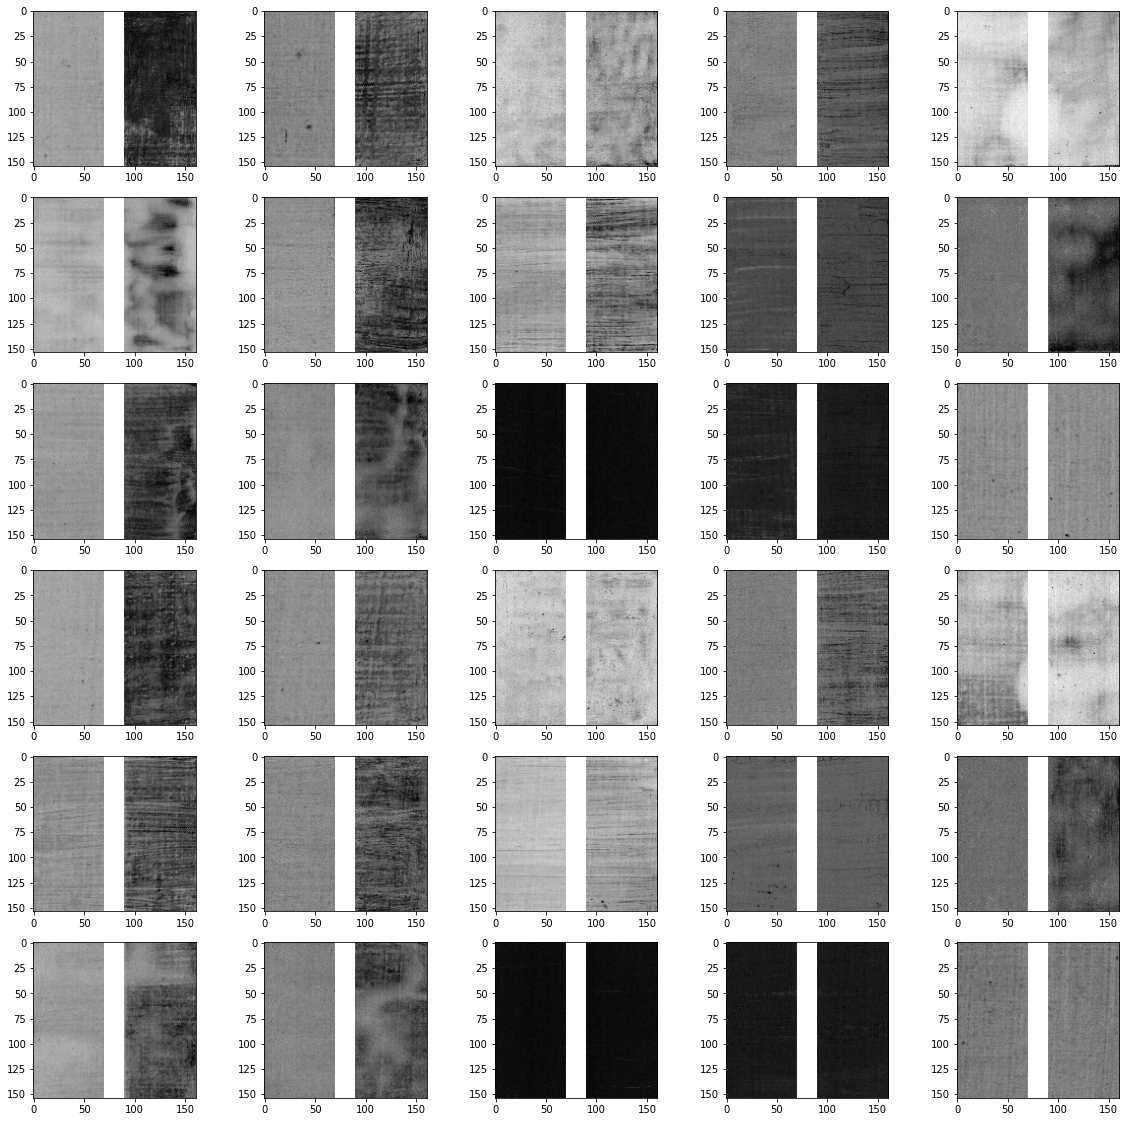

In [350]:
fig, axs = plt.subplots(6,int(len(pigments)/6),figsize=(20,20))
for i, pigment in enumerate(pigments):
    no_draw, draw = pigment
    merged_pigment = np.concatenate((no_draw,
                        np.ones((draw.shape[0], 20, draw.shape[-1])),
                        draw),
                       axis=1)
    axs[i % axs.shape[0], i // axs.shape[0]].imshow(
       merged_pigment[:,:,25],
       cmap='gray'
    )

In [ ]:
def get_pigment_dist(pigment, pad=1):
    assert len(pigment.shape) == 3, f"Expected 3 dimensional image, but get {len(pigment.shape)}"
    assert pad >= 1
    target_shape = (pad*2+1, pad*2+1, z_size)
    # TODO: Do not waste memory, size known
    samples = []
    for i in range(pad, pigment.shape[0]-1):
        for j in range(pad, pigment.shape[1]-1):
            sample =  pigment[i-pad:i+pad+1, j-pad:j+pad+1, :]
            # Normalize from 0 to 1
            assert sample.shape == target_shape
            # Flatten as feature vector
            samples.append(np.ravel(sample))
    samples = np.array(samples)
    covariance_matrix = np.cov(samples, rowvar=False)
    mean_vector = np.mean(samples, axis=0)
    assert mean_vector.shape == np.product(target_shape)
    assert covariance_matrix.shape == (np.product(target_shape), np.product(target_shape))
    # TODO: Is it okey to use 0 - 255
    # TODO: Normality test ??
    # TODO: pigment distribution class ???

    return multivariate_normal(mean=mean_vector,
                               cov=covariance_matrix,
                               allow_singular=False)

In [465]:
pigments_dist = []
for pigment in pigments:
    no_draw, draw = pigment
    pigments_dist.append({"underdrawing" : get_pigment_dist(draw),
                          "clear" : get_pigment_dist(no_draw)})


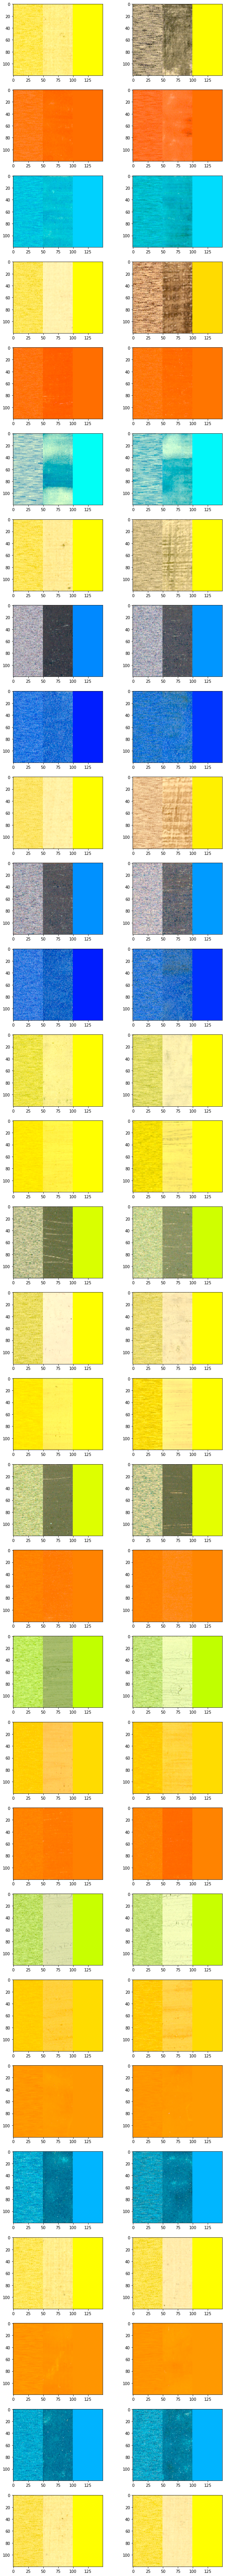

In [486]:
fig, axs = plt.subplots(30,2, figsize=(10,120))
for id, pig in enumerate(pigments):
    (ax1, ax2) = axs[id]
    im = []
    for i in range(50):
        l = []
        for s in pigments_dist[id]['clear'].rvs(20):
            l.append(np.reshape(s, (3,3,32)))
        im.append(l)
    im = np.reshape(np.array(im),(150, 60, 32))
    im[im < 0] = 0
    im[im > 1] = 1.0
    generated = wavelength2rgb(im[:,:,:16])[:120,:50,:]
    origin = wavelength2rgb(pig[0][:,:,:16])[:120,:50,:]
    mean = wavelength2rgb((np.ones((120,50, 32)) * np.mean(pig[0], axis=(0,1)))[:,:,:16])
    comp1 = np.concatenate((generated, origin,mean),axis=1)
    im = []
    for i in range(50):
        l = []
        for s in pigments_dist[id]['underdrawing'].rvs(20):
            l.append(np.reshape(s, (3,3,32)))
        im.append(l)
    im = np.reshape(np.array(im),(150, 60, 32))
    im[im < 0] = 0
    im[im > 1] = 1.0
    generated = wavelength2rgb(im[:,:,:16])[:120,:50,:]
    origin = wavelength2rgb(pig[1][:,:,:16])[:120,:50,:]
    mean = wavelength2rgb((np.ones((120,50, 32)) * np.mean(pig[1], axis=(0,1)))[:,:,:16])
    comp2 = np.concatenate((generated, origin, mean),axis=1)

    ax1.imshow(comp1)
    ax2.imshow(comp2)

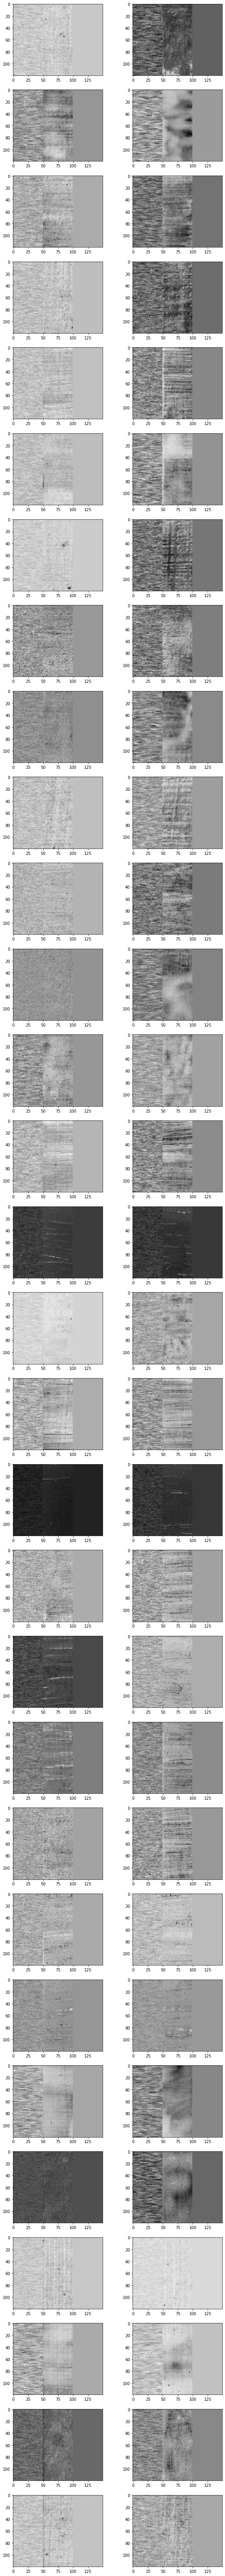

In [477]:
fig, axs = plt.subplots(30,2, figsize=(10,120))
for id, pig in enumerate(pigments):
    (ax1, ax2) = axs[id]
    im = []
    for i in range(50):
        l = []
        for s in pigments_dist[id]['clear'].rvs(20):
            l.append(np.reshape(s, (3,3,32)))
        im.append(l)
    im = np.reshape(np.array(im),(150, 60, 32))
    im[im < 0] = 0
    im[im > 1] = 1.0
    generated = im[:,:,22][:120,:50]
    origin = pig[0][:,:,22][:120,:50]
    mean = np.ones((120,50)) * np.mean(pig[0][:,:,22])
    comp1 = np.concatenate((generated, origin, mean),axis=1)
    im = []
    for i in range(50):
        l = []
        for s in pigments_dist[id]['underdrawing'].rvs(20):
            l.append(np.reshape(s, (3,3,32)))
        im.append(l)
    im = np.reshape(np.array(im),(150, 60, 32))
    im[im < 0] = 0
    im[im > 1] = 1.0
    generated = im[:,:,22][:120,:50]
    origin = pig[1][:,:,22][:120,:50]
    mean = np.ones((120,50)) * np.mean(pig[1][:,:,22])
    comp2 = np.concatenate((generated, origin,mean),axis=1)

    ax1.imshow(comp1, cmap='gray')
    ax2.imshow(comp2, cmap='gray')

In [484]:
x =
x.shape

(120, 50, 32)